# GP

Dataset loaded successfully.
No missing values found in 'Gbps'.

Performing feature engineering...

Total data points: 905
Training data points: 568
Test data points (last 15 days): 337
Forecast period starts: 2025-05-08 14:06:00
Forecast period ends: 2025-05-28 14:06:00

Performing hyperparameter tuning for XGBoost Regressor...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Best parameters found: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}
Best RMSE on training data (cross-validated): 6.2832

XGBoost Model training complete with best parameters.

Making predictions for the period from 2025-05-08 14:40:00 to 2025-05-28 14:06:00...

Model Evaluation for the last 15 days:
Root Mean Squared Error (RMSE): 6.4704
Mean Absolute Error (MAE): 4.2749


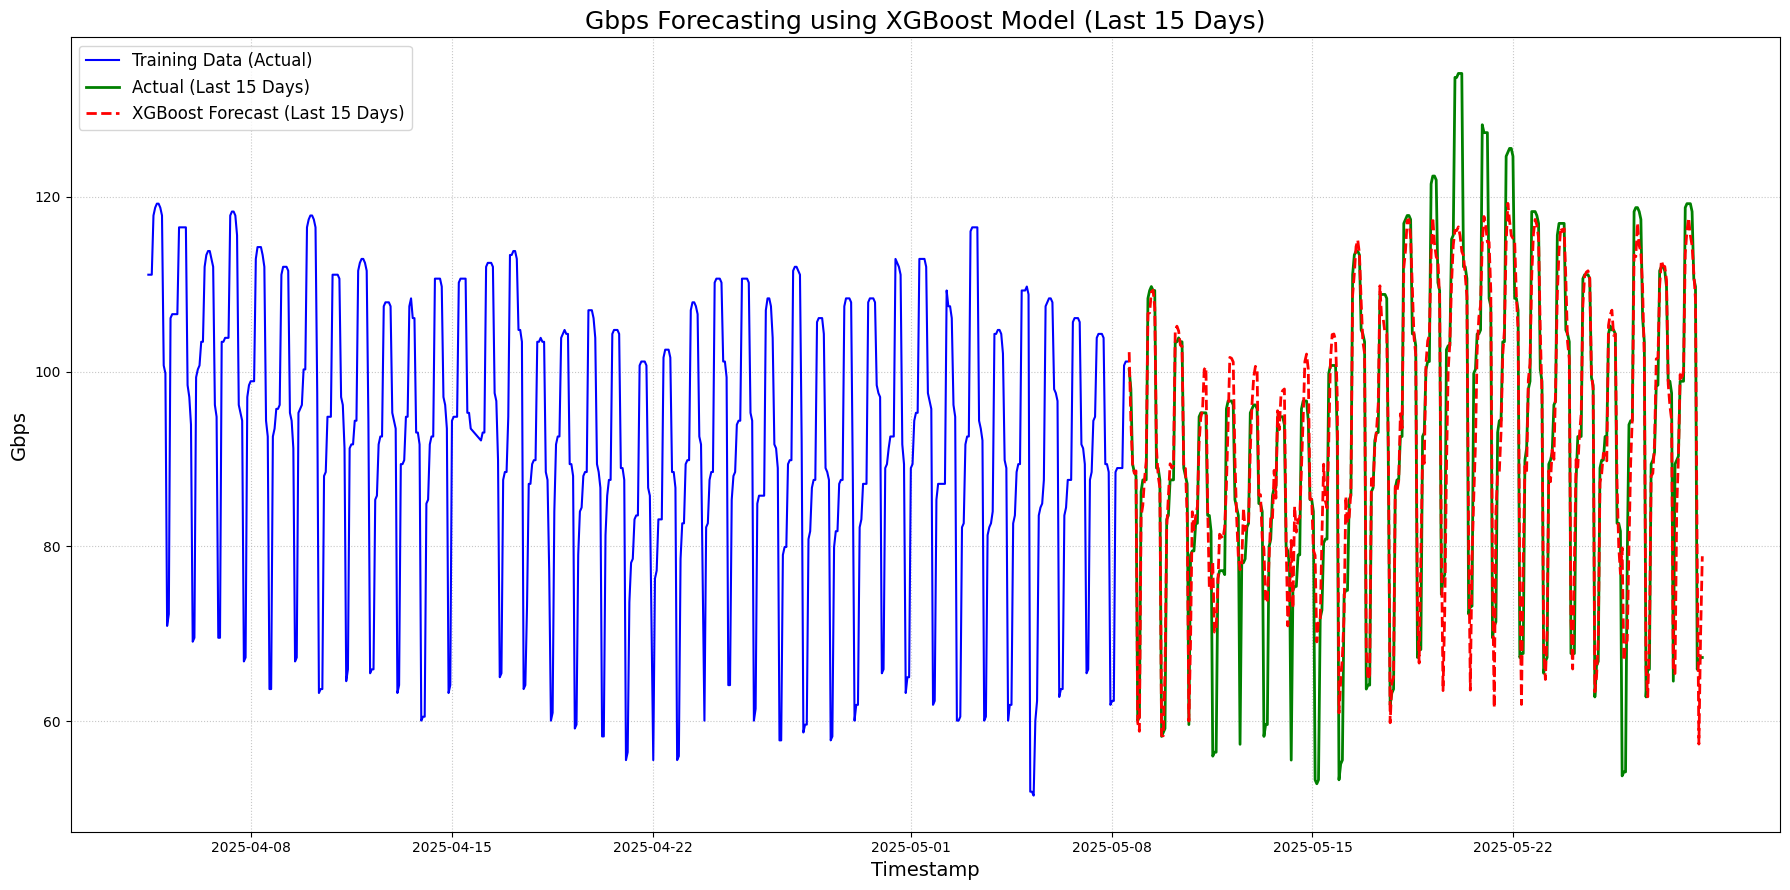


Forecasting complete. The plot shows the training data, actual values for the last 15 days, and the XGBoost model's predictions.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit #for hyperparameter tuning and time series aware cross validation

file_path = 'Last2_months_with_weekend_encoded_with_holiday_copy.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please upload the CSV file to your Colab environment or provide the correct path.")
    df = None

if df is None:
    print("Exiting due to file loading error.")
    raise SystemExit("File not found.")

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df = df.sort_index()

target_variable = 'Gbps'
data = df[target_variable]

initial_nan_count = data.isnull().sum()
if initial_nan_count > 0:
    print(f"Found {initial_nan_count} missing values in '{target_variable}'. Filling them...")
    data = data.ffill().bfill()
    if data.isnull().sum() > 0:
        print("Warning: Some NaNs still remain after ffill/bfill in target. Consider other imputation methods.")
else:
    print(f"No missing values found in '{target_variable}'.")

print("\nPerforming feature engineering...")
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['weekofyear'] = df.index.isocalendar().week.astype(int)

df['Gbps_lag1'] = df['Gbps'].shift(1)
df['Gbps_lag24'] = df['Gbps'].shift(24)
df['Gbps_lag24*7'] = df['Gbps'].shift(24*7)

df['Gbps_rolling_mean_3'] = df['Gbps'].rolling(window=3).mean()
df['Gbps_rolling_mean_24'] = df['Gbps'].rolling(window=24).mean()

for col in ['Gbps_lag1', 'Gbps_lag24', 'Gbps_lag24*7', 'Gbps_rolling_mean_3', 'Gbps_rolling_mean_24']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

features = [col for col in df.columns if col not in [target_variable, 'target']]

if 'event' in features:
    if df['event'].dtype == 'object':
        print("Warning: 'event' column is non-numeric. Applying one-hot encoding.")
        df = pd.get_dummies(df, columns=['event'], prefix='event', drop_first=True)
        features = [col for col in df.columns if col not in [target_variable, 'target']]
    elif df['event'].isnull().any():
        print("Warning: 'event' column has missing values. Filling with 0 for simplicity.")
        df['event'] = df['event'].fillna(0)

for col in features:
    if df[col].isnull().any():
        print(f"Warning: Feature '{col}' has missing values. Filling with its mean.")
        df[col] = df[col].fillna(df[col].mean())

X = df[features]
y = df[target_variable]

last_timestamp = y.index.max()
forecast_start_date = last_timestamp - pd.Timedelta(days=20)

X_train = X[X.index < forecast_start_date]
y_train = y[y.index < forecast_start_date]

X_test = X[X.index >= forecast_start_date]
y_test = y[y.index >= forecast_start_date]

print(f"\nTotal data points: {len(df)}")
print(f"Training data points: {len(y_train)}")
print(f"Test data points (last 15 days): {len(y_test)}")
print(f"Forecast period starts: {forecast_start_date}")
print(f"Forecast period ends: {last_timestamp}")

if y_test.empty:
    print("\nWarning: The test data for the last 15 days is empty.")
    print("This might happen if your dataset does not cover a full 15-day period at the end,")
    print("or if the timestamps are very sparse.")
    print("Please adjust the 'days' in pd.Timedelta(days=15) or check your data.")
    raise SystemExit("Test data is empty.")
elif len(y_test) < 5:
    print(f"\nWarning: Test data has only {len(y_test)} points. Evaluation might be less reliable.")

print("\nPerforming hyperparameter tuning for XGBoost Regressor...")

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

tscv = TimeSeriesSplit(n_splits=5) #split the whole validation time into 5 slices each of which will be sent back to training with each fold

grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best RMSE on training data (cross-validated): {-grid_search.best_score_:.4f}")

model = grid_search.best_estimator_
print("\nXGBoost Model training complete with best parameters.")

print(f"\nMaking predictions for the period from {y_test.index.min()} to {y_test.index.max()}...")
predictions = model.predict(X_test)
predictions_series = pd.Series(predictions, index=y_test.index)

if not y_test.empty:
    rmse = np.sqrt(mean_squared_error(y_test, predictions_series))
    mae = mean_absolute_error(y_test, predictions_series)

    print(f"\nModel Evaluation for the last 15 days:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
else:
    print("\nCannot evaluate model: Test data is empty or insufficient.")

plt.figure(figsize=(18, 9))
plt.plot(y_train.index, y_train, label='Training Data (Actual)', color='blue', linewidth=1.5)
plt.plot(y_test.index, y_test, label='Actual (Last 15 Days)', color='green', linewidth=2)
plt.plot(predictions_series.index, predictions_series, label='XGBoost Forecast (Last 15 Days)', color='red', linestyle='--', linewidth=2)
plt.title('Gbps Forecasting using XGBoost Model (Last 15 Days)', fontsize=18)
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Gbps', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nForecasting complete. The plot shows the training data, actual values for the last 15 days, and the XGBoost model's predictions.")


### ROBI


Dataset loaded successfully.
No missing values found in 'Gbps'.

Performing feature engineering...

Total data points: 888
Training data points: 596
Test data points (last 15 days): 292
Forecast period starts: 2025-05-13 10:56:00
Forecast period ends: 2025-06-02 10:56:00

Performing hyperparameter tuning for XGBoost Regressor...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Best parameters found: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
Best RMSE on training data (cross-validated): 15.2560

XGBoost Model training complete with best parameters.

Making predictions for the period from 2025-05-13 11:11:00 to 2025-06-02 10:56:00...

Model Evaluation for the last 15 days:
Root Mean Squared Error (RMSE): 15.8956
Mean Absolute Error (MAE): 11.1990


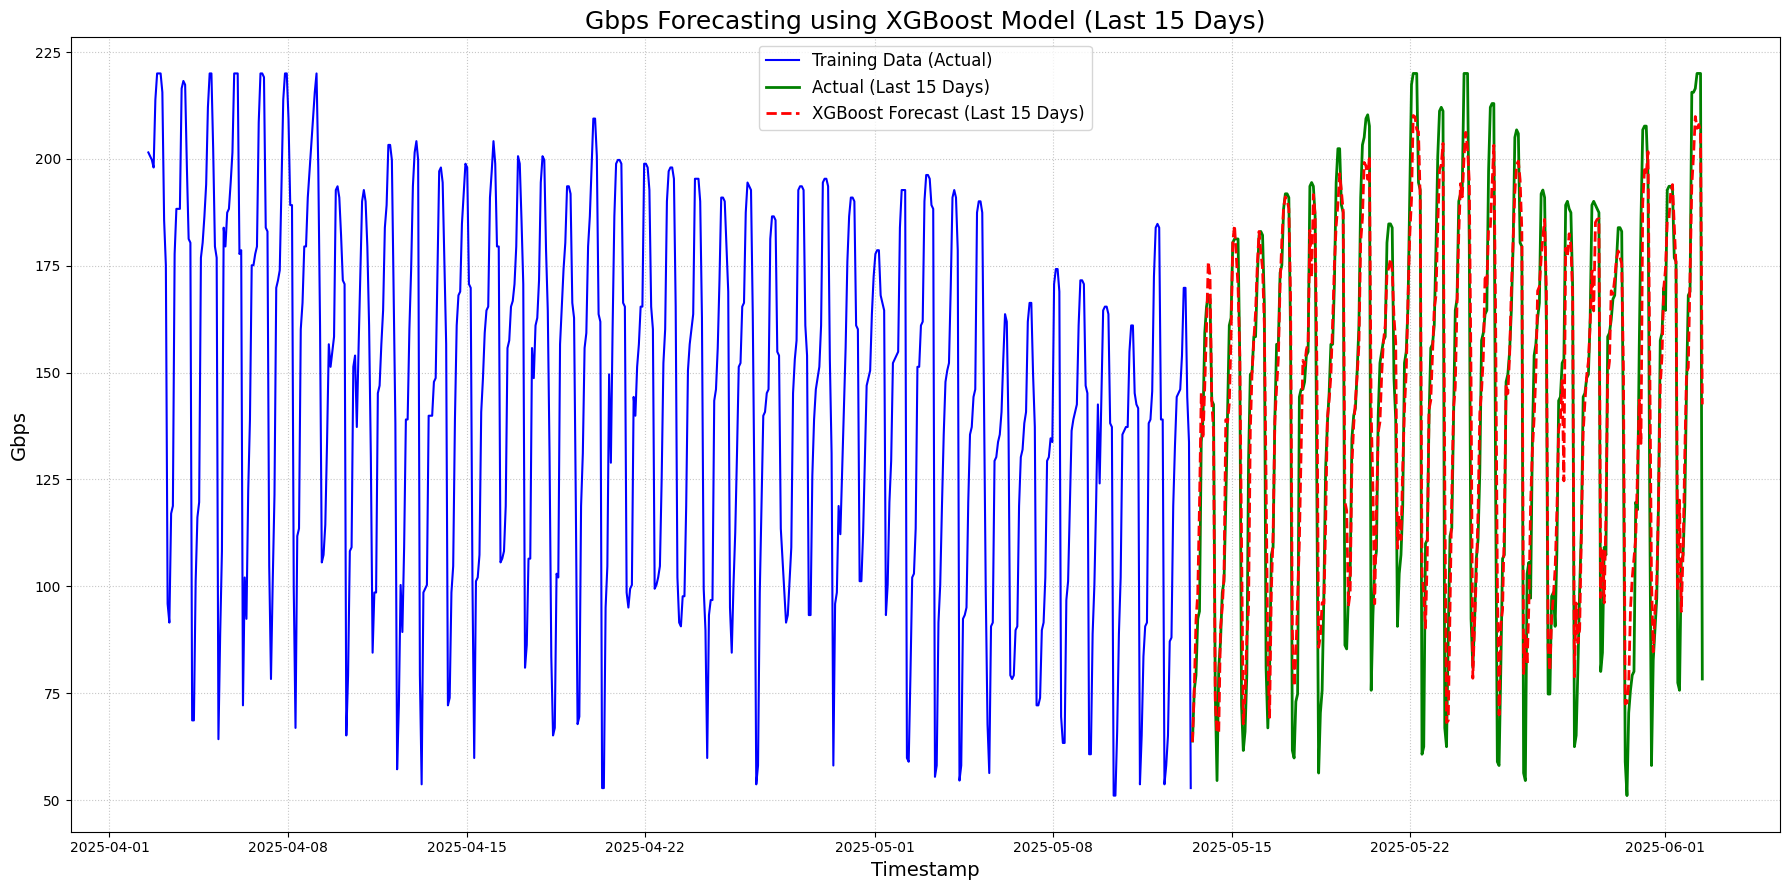


Forecasting complete. The plot shows the training data, actual values for the last 15 days, and the XGBoost model's predictions.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

file_path = '/content/Robi_DHAKA3_with_weekend_flag.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please upload the CSV file to your Colab environment or provide the correct path.")
    df = None

if df is None:
    print("Exiting due to file loading error.")
    raise SystemExit("File not found.")

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df = df.sort_index()

target_variable = 'Gbps'
data = df[target_variable]

initial_nan_count = data.isnull().sum()
if initial_nan_count > 0:
    print(f"Found {initial_nan_count} missing values in '{target_variable}'. Filling them...")
    data = data.ffill().bfill()
    if data.isnull().sum() > 0:
        print("Warning: Some NaNs still remain after ffill/bfill in target. Consider other imputation methods.")
else:
    print(f"No missing values found in '{target_variable}'.")

print("\nPerforming feature engineering...")
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['weekofyear'] = df.index.isocalendar().week.astype(int)

df['Gbps_lag1'] = df['Gbps'].shift(1)
df['Gbps_lag24'] = df['Gbps'].shift(24)
df['Gbps_lag24*7'] = df['Gbps'].shift(24*7)

df['Gbps_rolling_mean_3'] = df['Gbps'].rolling(window=3).mean()
df['Gbps_rolling_mean_24'] = df['Gbps'].rolling(window=24).mean()

for col in ['Gbps_lag1', 'Gbps_lag24', 'Gbps_lag24*7', 'Gbps_rolling_mean_3', 'Gbps_rolling_mean_24']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

features = [col for col in df.columns if col not in [target_variable, 'target']]

if 'event' in features:
    if df['event'].dtype == 'object':
        print("Warning: 'event' column is non-numeric. Applying one-hot encoding.")
        df = pd.get_dummies(df, columns=['event'], prefix='event', drop_first=True)
        features = [col for col in df.columns if col not in [target_variable, 'target']]
    elif df['event'].isnull().any():
        print("Warning: 'event' column has missing values. Filling with 0 for simplicity.")
        df['event'] = df['event'].fillna(0)

for col in features:
    if df[col].isnull().any():
        print(f"Warning: Feature '{col}' has missing values. Filling with its mean.")
        df[col] = df[col].fillna(df[col].mean())

X = df[features]
y = df[target_variable]

last_timestamp = y.index.max()
forecast_start_date = last_timestamp - pd.Timedelta(days=20)

X_train = X[X.index < forecast_start_date]
y_train = y[y.index < forecast_start_date]

X_test = X[X.index >= forecast_start_date]
y_test = y[y.index >= forecast_start_date]

print(f"\nTotal data points: {len(df)}")
print(f"Training data points: {len(y_train)}")
print(f"Test data points (last 15 days): {len(y_test)}")
print(f"Forecast period starts: {forecast_start_date}")
print(f"Forecast period ends: {last_timestamp}")

if y_test.empty:
    print("\nWarning: The test data for the last 15 days is empty.")
    print("This might happen if your dataset does not cover a full 15-day period at the end,")
    print("or if the timestamps are very sparse.")
    print("Please adjust the 'days' in pd.Timedelta(days=15) or check your data.")
    raise SystemExit("Test data is empty.")
elif len(y_test) < 5:
    print(f"\nWarning: Test data has only {len(y_test)} points. Evaluation might be less reliable.")

print("\nPerforming hyperparameter tuning for XGBoost Regressor...")

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best RMSE on training data (cross-validated): {-grid_search.best_score_:.4f}")

model = grid_search.best_estimator_
print("\nXGBoost Model training complete with best parameters.")

print(f"\nMaking predictions for the period from {y_test.index.min()} to {y_test.index.max()}...")
predictions = model.predict(X_test)
predictions_series = pd.Series(predictions, index=y_test.index)

if not y_test.empty:
    rmse = np.sqrt(mean_squared_error(y_test, predictions_series))
    mae = mean_absolute_error(y_test, predictions_series)
    print(f"\nModel Evaluation for the last 15 days:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
else:
    print("\nCannot evaluate model: Test data is empty or insufficient.")

plt.figure(figsize=(18, 9))
plt.plot(y_train.index, y_train, label='Training Data (Actual)', color='blue', linewidth=1.5)
plt.plot(y_test.index, y_test, label='Actual (Last 15 Days)', color='green', linewidth=2)
plt.plot(predictions_series.index, predictions_series, label='XGBoost Forecast (Last 15 Days)', color='red', linestyle='--', linewidth=2)
plt.title('Gbps Forecasting using XGBoost Model (Last 15 Days)', fontsize=18)
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Gbps', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nForecasting complete. The plot shows the training data, actual values for the last 15 days, and the XGBoost model's predictions.")
